In [1]:
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import torch
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16, VGG
from torchvision import transforms
from scipy import ndimage
from PIL import Image as pil
import numpy as np
from tqdm import tqdm
import ast

In [59]:
import cv2

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

In [ ]:
loss.backward()
optimizer.step()
optimizer.zero_grad()

Во фреймворке Pytorch ккласс `torch.Tensor` имеет поле `grad` в котором хранится градиент. По умолчанию знамение поля `None`

In [5]:
random_tensor = torch.rand((1,3,224,224))

In [7]:
random_tensor.grad is None

True

У класса `torch.Tensor` так же есть поле `requires_grad` указывающее на то необходимо ли вычислять градиент для данного тензора в ходе backpropagation.

In [8]:
random_tensor.requires_grad

False

Мы можем видеть, что сейчас тензор является константой с точки зрения Pytorch. Переключим его в другой режим

In [9]:
random_tensor = random_tensor.requires_grad_(True)

In [15]:
random_tensor2 = torch.rand((1,3,224,224))

In [16]:
random_tensor2 = random_tensor2.requires_grad_(True)

Метод `backward()` класса `torch.Tensor` необходим для вычисления градиента по всем тензорам со значением `random_tensor.requires_grad == True`

Реализация Pytorch и движка autograd позволяют вычислять градиент только по скалярам. Чтобы пример выполнялся необходимо тем или иным обзаром сагрегировать значения тензора. Например, просуммировав:

In [17]:
y = random_tensor.sum()

In [30]:
y2 = torch.square(random_tensor).sum()

Таким образом мы задали функцию 
$$y = \sum x_{i,j,k,m} $$ 
Теперь вызов `y.backward()` рассчитает градиент 
$$\nabla_x y$$
и заполнит поле `grad` у переменной `random_tensor`

In [18]:
y.backward()

In [20]:
random_tensor.grad is None, random_tensor.grad.shape

(False, torch.Size([1, 3, 224, 224]))

In [22]:
random_tensor2.grad is None

True

In [25]:
random_tensor.grad = None

In [26]:
random_tensor.grad

Ожидаемо получаем тензор заполненный 1. Если вызвать `y.backward()` повторно, то вычисленный градиент прибавится ко значению, находящемуся в `random_tensor.grad`

In [32]:
y2.backward()

In [35]:
random_tensor.grad

tensor([[[[4.8232, 4.2164, 3.5977,  ..., 3.0256, 4.7003, 4.1699],
          [4.6062, 4.7954, 4.7943,  ..., 4.6779, 3.1192, 3.3078],
          [3.4665, 3.3537, 3.0097,  ..., 4.5529, 4.2027, 3.9654],
          ...,
          [3.2984, 4.9518, 3.3942,  ..., 3.1733, 4.7698, 3.9952],
          [4.4019, 3.2176, 4.3203,  ..., 3.6938, 4.5143, 3.9684],
          [4.9207, 4.4109, 3.1794,  ..., 3.4040, 3.9799, 3.3969]],

         [[3.6286, 4.1768, 4.0195,  ..., 4.9845, 4.5530, 4.6110],
          [4.2817, 3.2298, 3.7347,  ..., 4.7940, 4.5037, 4.0633],
          [3.7055, 4.4932, 4.4836,  ..., 4.9852, 4.2913, 4.0444],
          ...,
          [3.0151, 3.9213, 3.8738,  ..., 4.7979, 4.8364, 4.1084],
          [3.3594, 4.0345, 3.7349,  ..., 3.6177, 4.3391, 3.5489],
          [4.7939, 4.7942, 4.3481,  ..., 4.1240, 3.1072, 3.5039]],

         [[3.3855, 4.7982, 3.0248,  ..., 4.1506, 4.1956, 3.7090],
          [3.1957, 3.6479, 4.0750,  ..., 4.1834, 3.6155, 3.9431],
          [4.3440, 3.7331, 3.6409,  ..., 3

In [29]:
y.backward()
random_tensor.grad

tensor([[[[3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          ...,
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.]],

         [[3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          ...,
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.]],

         [[3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          ...,
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.],
          [3., 3., 3.,  ..., 3., 3., 3.]]]])

Таким образом, чтобы избежать нежелательных эффектов необходимо сбрасывать градиент между вызовами `backward()`

In [36]:
random_tensor.grad = None

Рассмотрим случай, когда используется оптимизатор, например `optim.Adam`. Первым аргументом являются параметры модели. Вы уже знаете, что в классе nn.Module их можно получить в поле `params`. В слчае с нашим примером параметрами является `random_tensor`.  

In [37]:
optimizer = torch.optim.Adam([random_tensor])

Следующий код является типичным шагом оптимизации нейронных сетей:

In [38]:
y.backward() # рассчитываем градиент, т.е. заполняет поле grad у всех тензоров от которых зависит y
optimizer.step() # применяем градиент к параметрам, переданным в конструктор класса оптимизатора
optimizer.zero_grad() # не забываем обнулить градиенты. 
#Параметр set_to_none позволяет сэкономить память, но может привести к нежелательным эффектам

В Pytorch градиент может быть получен не только вызовом `backward` но и явно при помощи низкоуровневого движка автодифференцирования `autograd`. Данный код вычисляет градиент y по random_tensor

In [46]:
(grad, ) = autograd.grad(y, inputs=random_tensor) 

In [47]:
grad

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

Параметр `create_graph` функции `autograd.grad` отвечает за то строится ли граф зависмостей для получаемого градиента. Если установить значение параметра в `true` то полученный градиент будет трактоваться как узел в вычислительном графе и может быть использован в градиентом спуске. Такая техника часто применяется при регуляризации в частности в `generative adversarial networks`

Теперь воспользуемся полученными знаниями восроизведём пример вычисления saliency map, описанный еа лекции:

In [69]:
normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

In [84]:
def load_image(path: str) -> torch.Tensor:
    assert os.path.exists(path)
    img_cv = cv2.imread(path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    x = transforms.ToPILImage()(img_cv)
    x = transforms.Resize((224, 224))(x)
    x = transforms.ToTensor()(x)
    x = normalize_imagenet(x)
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((224, 224)),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])
    return x[None, :, :, :]

In [93]:
def compute_saliency_map(model: VGG, class_id: int, image_tensor: torch.Tensor):
    
    image_tensor.requires_grad_(True)
    y = model(image_tensor)[:, class_id]
    (grad, ) = autograd.grad(y, inputs=image_tensor, create_graph=False)
    
    
    saliency_map = torch.abs(grad.cpu().detach())
    
    return saliency_map

In [51]:
def tensor2image(image_tensor: torch.Tensor) -> np.ndarray:
    image_tensor = image_tensor[0]  # выбираем единственный элемент
    image_tensor = image_tensor.permute((1, 2, 0))  # [channels, height, width] -> [height, width, channels]
    image_numpy = image_tensor.detach().cpu().numpy()  # конвертируем в numpy
    return image_numpy

In [52]:
def renormalize_image(x: np.ndarray) -> np.ndarray: 
    x = (x - np.min(x)) 
    x = x / np.max(x) * 255

    return x.astype(np.uint8)

In [53]:
model = vgg16(pretrained = True)

In [54]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [103]:
img_tensor = load_image('1617744656_23-p-koshka-oboi-koshachii-lemur-38.jpg')

In [96]:
with open("imagenet_class_index.json", "r") as file:
    contents = file.read()
    imagenet_labels = ast.literal_eval(contents)

In [97]:
imagenet_labels = dict([(int(k),v[1]) for k,v in imagenet_labels.items()])

In [74]:
imagenet_labels

{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house_finch',
 13: 'junco',
 14: 'indigo_bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water_ouzel',
 21: 'kite',
 22: 'bald_eagle',
 23: 'vulture',
 24: 'great_grey_owl',
 25: 'European_fire_salamander',
 26: 'common_newt',
 27: 'eft',
 28: 'spotted_salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree_frog',
 32: 'tailed_frog',
 33: 'loggerhead',
 34: 'leatherback_turtle',
 35: 'mud_turtle',
 36: 'terrapin',
 37: 'box_turtle',
 38: 'banded_gecko',
 39: 'common_iguana',
 40: 'American_chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled_lizard',
 44: 'alligator_lizard',
 45: 'Gila_monster',
 46: 'green_lizard',
 47: 'African_chameleon',
 48: 'Komodo_dragon',
 49: 'African_crocodile',
 50: 'American_alligator',
 51: 'triceratops',
 

In [75]:
imagenet_labels[383]

'Madagascar_cat'

In [104]:
mp = compute_saliency_map(model, 383, img_tensor)

In [105]:
saliency_map = tensor2image(mp).max(-1)
image = renormalize_image(tensor2image(img_tensor))

In [106]:
heatmap = ndimage.gaussian_filter(saliency_map[:,:,None] , 8, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

In [107]:
heatmap = renormalize_image(heatmap) / 255

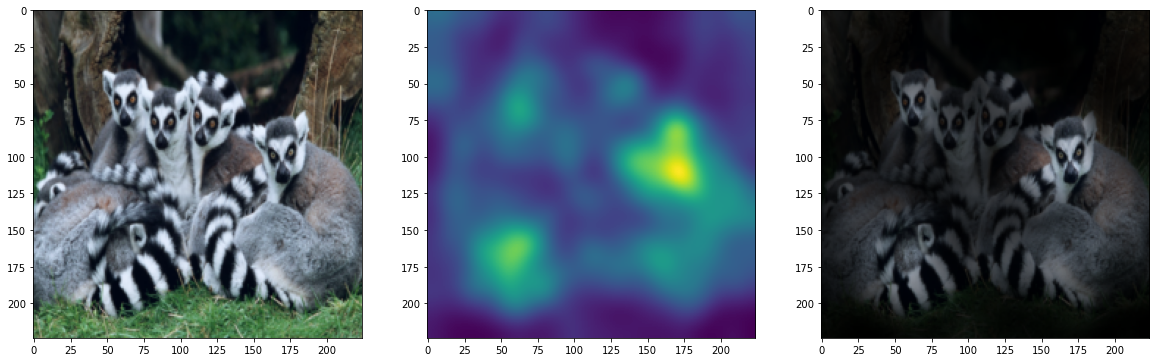

In [108]:
fig = plt.figure()
ax = fig.add_subplot(1,3,1)
ax.imshow(image)
ax = fig.add_subplot(1,3,2)
ax.imshow(heatmap[:,:,0])
ax = fig.add_subplot(1,3,3)
ax.imshow((image * heatmap).astype(np.uint8))